In [47]:
"""
FID, IS, JS divergence.
"""

import numpy as np
import os
import copy
import tempfile
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn.functional as F
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import kurtosis, skew
from scipy.special import entr

from models.stage2.maskgit import MaskGIT
from models.stage2.full_embedding_maskgit import Full_Embedding_MaskGIT
from preprocessing.preprocess_ucr import UCRDatasetImporter
from models.stage2.sample import unconditional_sample, conditional_sample
from supervised_FCN.example_pretrained_model_loading import load_pretrained_FCN
from supervised_FCN.example_compute_FID import calculate_fid
from supervised_FCN.example_compute_IS import calculate_inception_score
from utils import time_to_timefreq, timefreq_to_time, model_filename
import seaborn as sns
import pandas as pd


class Evaluation(object):
    """
    - FID
    - IS
    - visual inspection
    - PCA
    - t-SNE
    """

    def __init__(
        self,
        subset_dataset_name: str,
        gpu_device_index: int,
        config: dict,
        batch_size: int = 256,
    ):
        self.subset_dataset_name = subset_dataset_name
        self.device = "cpu"
        self.batch_size = batch_size
        self.config = config

        # # load the pretrained FCN
        # self.fcn = load_pretrained_FCN(subset_dataset_name)
        # self.fcn.eval()

        # load the numpy matrix of the test samples
        dataset_importer = UCRDatasetImporter(subset_dataset_name, data_scaling=True)
        self.X_test = dataset_importer.X_test[:, None, :]
        n_fft = self.config["VQVAE"]["n_fft"]
        self.X_test = timefreq_to_time(
            time_to_timefreq(torch.from_numpy(self.X_test), n_fft, 1), n_fft, 1
        )
        self.X_test = self.X_test.numpy()

        self.X_train = dataset_importer.X_train[:, None, :]
        n_fft = self.config["VQVAE"]["n_fft"]
        self.X_train = timefreq_to_time(
            time_to_timefreq(torch.from_numpy(self.X_train), n_fft, 1), n_fft, 1
        )
        # self.X_train = self.X_train.numpy()

    def getTrain(self):
        return self.X_train

    def sampleMaskGit(
        self,
        n_samples: int,
        input_length: int,
        n_classes: int,
        kind: str,
        class_index: int = -1,
    ):
        assert kind in ["unconditional", "conditional"]

        # build
        maskgit = MaskGIT(
            input_length,
            **self.config["MaskGIT"],
            config=self.config,
            n_classes=n_classes,
        )
        # load
        fname = (
            f"{model_filename(self.config, 'maskgit')}-{self.subset_dataset_name}.ckpt"
        )
        try:
            ckpt_fname = os.path.join("saved_models", fname)
            maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
        except FileNotFoundError:
            ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
            maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)

        # inference mode
        maskgit.eval()

        # sampling
        if kind == "unconditional":
            x_new = unconditional_sample(
                maskgit, n_samples, self.device, batch_size=self.batch_size
            )  # (b c l); b=n_samples, c=1 (univariate)
        elif kind == "conditional":
            x_new = conditional_sample(
                maskgit, n_samples, self.device, class_index, self.batch_size
            )  # (b c l); b=n_samples, c=1 (univariate)
        else:
            raise ValueError

        return x_new

    def sampleFullEmbedMaskGit(
        self,
        n_samples: int,
        input_length: int,
        n_classes: int,
        kind: str,
        device: torch.device,
        class_index: int = -1,
        load_finetuned_codebook: bool = False,
    ):
        assert kind in ["unconditional", "conditional"]

        # build
        maskgit = Full_Embedding_MaskGIT(
            input_length,
            **self.config["MaskGIT"],
            config=self.config,
            n_classes=n_classes,
            finetune_codebook=False,
            device=device,
            load_finetuned_codebook=load_finetuned_codebook,
        ).to(self.device)

        # load
        model_name = "maskgit"
        fname = (
            f"{model_filename(self.config, model_name)}-{self.subset_dataset_name}.ckpt"
        )
        try:
            ckpt_fname = os.path.join("saved_models", fname)
            maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
        except FileNotFoundError:
            ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
            maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)

        # inference mode
        maskgit.eval()

        # sampling
        if kind == "unconditional":
            x_new = unconditional_sample(
                maskgit, n_samples, self.device, batch_size=self.batch_size
            )  # (b c l); b=n_samples, c=1 (univariate)
        elif kind == "conditional":
            x_new = conditional_sample(
                maskgit, n_samples, self.device, class_index, self.batch_size
            )  # (b c l); b=n_samples, c=1 (univariate)
        else:
            raise ValueError

        return x_new

    def compute_z(self, X_gen: torch.Tensor) -> (np.ndarray, np.ndarray):
        """
        It computes representation z given input x
        :param X_gen: generated X
        :return: z_test (z on X_test), z_gen (z on X_generated)
        """
        n_samples = self.X_test.shape[0]
        n_iters = n_samples // self.batch_size
        if n_samples % self.batch_size > 0:
            n_iters += 1

        # get feature vectors from `X_test` and `X_gen`
        z_test, z_gen = [], []
        for i in range(n_iters):
            s = slice(i * self.batch_size, (i + 1) * self.batch_size)

            z_t = (
                self.fcn(
                    torch.from_numpy(self.X_test[s]).float(),
                    return_feature_vector=True,
                )
                .cpu()
                .detach()
                .numpy()
            )
            z_g = (
                self.fcn(X_gen[s].float(), return_feature_vector=True)
                .cpu()
                .detach()
                .numpy()
            )

            z_test.append(z_t)
            z_gen.append(z_g)
        z_test, z_gen = np.concatenate(z_test, axis=0), np.concatenate(z_gen, axis=0)
        return z_test, z_gen

    def fid_score(
        self, z_test: np.ndarray, z_gen: np.ndarray
    ) -> (int, (np.ndarray, np.ndarray)):
        fid = calculate_fid(z_test, z_gen)
        return fid, (z_test, z_gen)

    def inception_score(self, X_gen: torch.Tensor):
        # assert self.X_test.shape[0] == X_gen.shape[0], "shape of `X_test` must be the same as that of `X_gen`."

        n_samples = self.X_test.shape[0]
        n_iters = n_samples // self.batch_size
        if n_samples % self.batch_size > 0:
            n_iters += 1

        # get the softmax distribution from `X_gen`
        p_yx_gen = []
        for i in range(n_iters):
            s = slice(i * self.batch_size, (i + 1) * self.batch_size)

            p_yx_g = self.fcn(X_gen[s].float())  # p(y|x)
            p_yx_g = torch.softmax(p_yx_g, dim=-1).cpu().detach().numpy()

            p_yx_gen.append(p_yx_g)
        p_yx_gen = np.concatenate(p_yx_gen, axis=0)

        IS_mean, IS_std = calculate_inception_score(p_yx_gen)
        return IS_mean, IS_std


In [48]:
from preprocessing.augmentations import Augmenter
from preprocessing.augmentations import TimeAugmenter


In [49]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from utils import load_yaml_param_settings
conf_dir = 'configs/config.yaml'

config = load_yaml_param_settings(conf_dir)

In [79]:
augmenter = Augmenter(**config['augmentations'])
# timeaug = TimeAugmenter(*config)

In [80]:
eval = Evaluation(subset_dataset_name="ElectricDevices",gpu_device_index=0, config=config, )

self.X_train.shape: (8926, 96)
self.X_test.shape: (7711, 96)
# unique labels (train): [0 1 2 3 4 5 6]
# unique labels (test): [0 1 2 3 4 5 6]


In [53]:
n_classes = 2
input_length = 500

In [81]:
x_train = eval.getTrain()



In [84]:
num_augs = 5
time_series = x_train[50][0][:]
aug_time_series = []
for i in range(num_augs):
    aug_time_series.append(augmenter.augment(time_series))

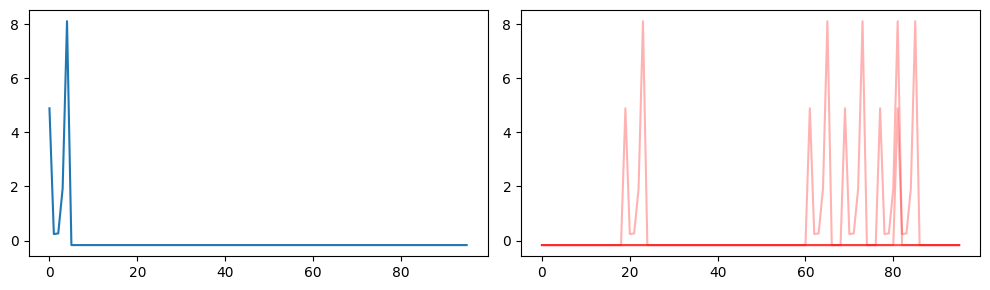

In [86]:
# fig, axes = plt.subplots(2,1, figsize=(10, 4))

# axes[1,1].plot(time_series)
# for i in range(num_augs):
#     axes[2,1].plot(aug_time_series[i], color = 'red', alpha = 0.3)
# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 2 rows, 1 column

axes[0].plot(time_series)  # Plotting the original time series on the first subplot
# axes[0].set_title('Original')
for i in range(num_augs):
    axes[1].plot(aug_time_series[i], color='red', alpha=0.3)  # Plotting each augmented time series on the second subplot
# axes[1].set_title('Augmented')
plt.tight_layout()  # Adjusts the spacing between the subplots to fit into the figure area
plt.show()  # Display the plot

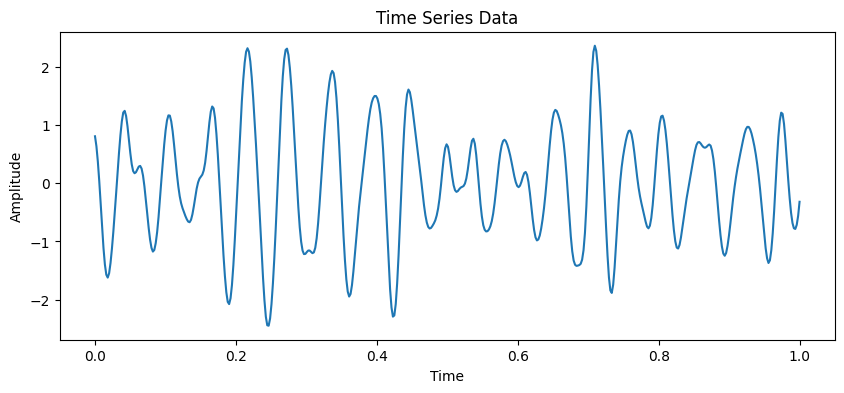

torch.Size([5, 251, 2])
torch.Size([500])


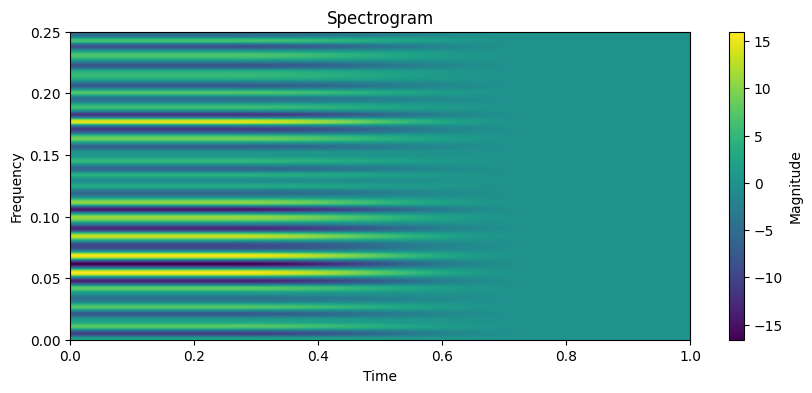

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Generate some sample time series data
# Here, we'll generate a simple sinusoidal wave
t = torch.linspace(0, 1, input_length)
# time_series = torch.sin(2 * torch.pi * 5 * t) + 0.5 * torch.sin(2 * torch.pi * 10 * t)
time_series = x_train[1][0][:]


# Plot the time series data
plt.figure(figsize=(10, 4))
plt.plot(t.numpy(), time_series.numpy())
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Perform Short-Time Fourier Transform (SFFT)
# You can adjust parameters like window size, hop length, etc.
window_size = 64
hop_length = 10
# fft = torch.stft(time_series, window_size, hop_length, return_complex=True)
fft = torch.stft(time_series,n_fft=8, return_complex=True)


# Get the magnitude of the complex values
fft = torch.view_as_real(fft)
print(fft.shape)
print(time_series.shape)

magnitude = fft[:][:][0]

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(magnitude.numpy(), aspect='auto', origin='lower', 
           extent=[0, 1, 0, 0.5 * 500 / 1000], cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude')
plt.show()


In [34]:
fft[:][:][:].shape
fft

tensor([[[ 2.5593,  0.0000],
         [ 1.7793,  0.0000],
         [-1.7373,  0.0000],
         ...,
         [-4.6105,  0.0000],
         [-5.1176,  0.0000],
         [-5.2193,  0.0000]],

        [[-1.9911, -0.0000],
         [-0.5515, -2.5426],
         [ 1.1058, -3.4730],
         ...,
         [ 0.9941,  0.3006],
         [-0.4452,  0.5469],
         [-0.5469, -0.5469]],

        [[-0.2834,  0.0000],
         [ 0.2834, -0.7800],
         [ 1.2013, -1.2520],
         ...,
         [ 0.2009,  0.1327],
         [ 0.1017, -0.3372],
         [ 0.0000,  0.3372]],

        [[-0.3029,  0.0000],
         [ 0.5515, -0.2487],
         [ 1.1882, -0.5038],
         ...,
         [ 0.0612,  0.0539],
         [ 0.1985,  0.0968],
         [ 0.0968, -0.0968]],

        [[-0.1353,  0.0000],
         [ 0.6447,  0.0000],
         [ 1.1921,  0.0000],
         ...,
         [ 0.0309,  0.0000],
         [-0.0672,  0.0000],
         [-0.1689,  0.0000]]], dtype=torch.float64)

In [34]:
x_aug = torch.empty(size = x_train.shape)
for i in range(x_train.shape[0]):
    x_aug[i] = augmenter.augment(x_train[i][0][:])


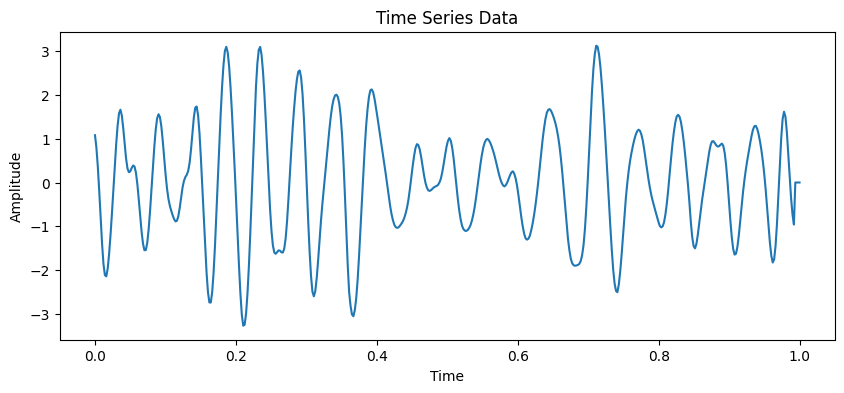

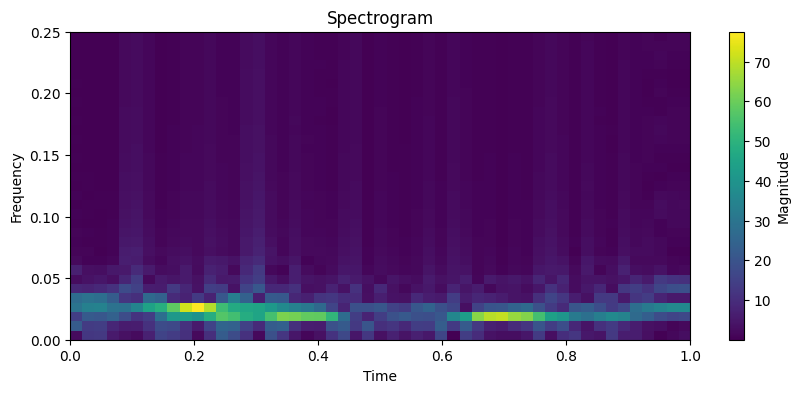

In [37]:
# Generate some sample time series data
# Here, we'll generate a simple sinusoidal wave
t = torch.linspace(0, 1, input_length)
# time_series = torch.sin(2 * torch.pi * 5 * t) + 0.5 * torch.sin(2 * torch.pi * 10 * t)
time_series = x_aug[1][0][:]

# Plot the time series data
plt.figure(figsize=(10, 4))
plt.plot(t.numpy(), time_series.numpy())
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Perform Short-Time Fourier Transform (SFFT)
# You can adjust parameters like window size, hop length, etc.
window_size = 64
hop_length = 10
fft = torch.stft(time_series, window_size, hop_length, return_complex=True)

# Get the magnitude of the complex values
magnitude = torch.abs(fft)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(magnitude.numpy(), aspect='auto', origin='lower', 
           extent=[0, 1, 0, 0.5 * 500 / 1000], cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude')
plt.show()

In [11]:
x_aug = torch.empty(size = x_train.shape)
for i in range(x_train.shape[0]):
    x_aug[i] = augmenter.augment(x_train[i][0][:])


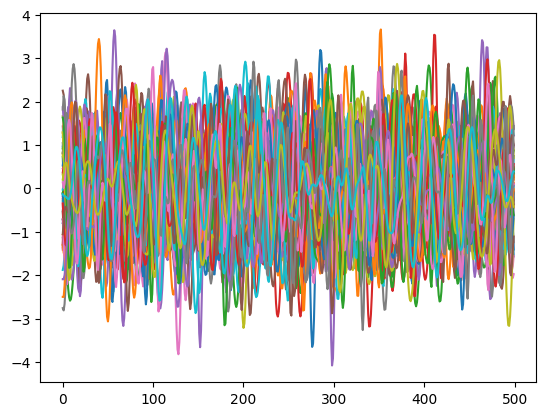

In [10]:
samples = 50 

# for i in range(samples):
#     plt.plot(x_aug[i][0][:])
# plt.show()
for i in range(samples):
    # rnd = np.random.random_integers(0,x_train.shape[0],size = samples)
    # plt.plot(x_train[rnd[i]][0][:])
    plt.plot(x_train[i][0][:])

plt.show()

In [16]:
# class_con = []
# for i in range(n_classes):
#     x_gen = eval.sampleMaskGit(10, input_length=input_length, n_classes=n_classes,class_index= i, kind= "conditional")
#     class_con.append(x_gen)


/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
encoder-FordA.ckpt
None encoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
decoder-FordA.ckpt
None decoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-FordA.ckpt
None vqmodel loaded


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
encoder-FordA.ckpt
None encoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
decoder-FordA.ckpt
None decoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-FordA.ckpt
None vqmodel loaded


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


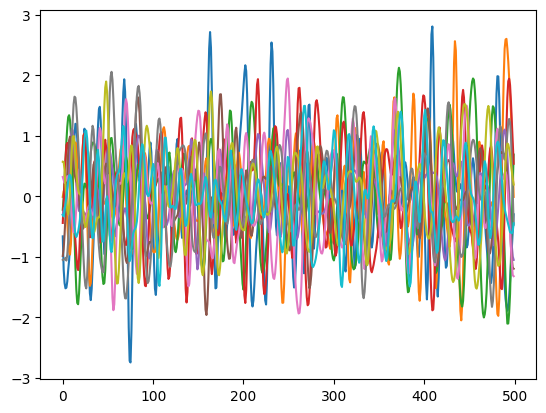

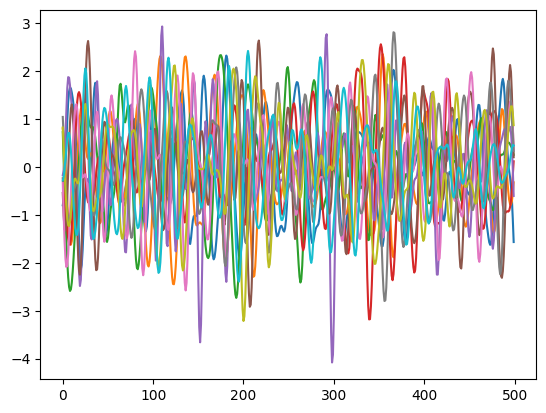

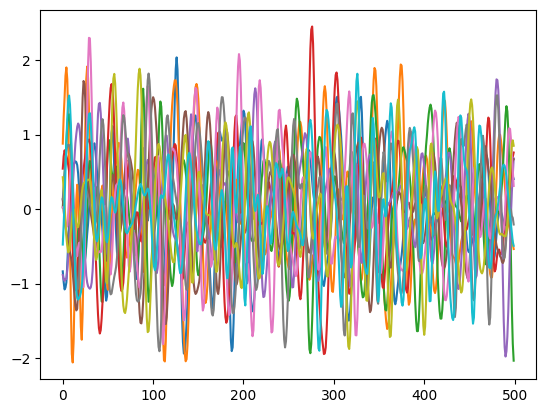

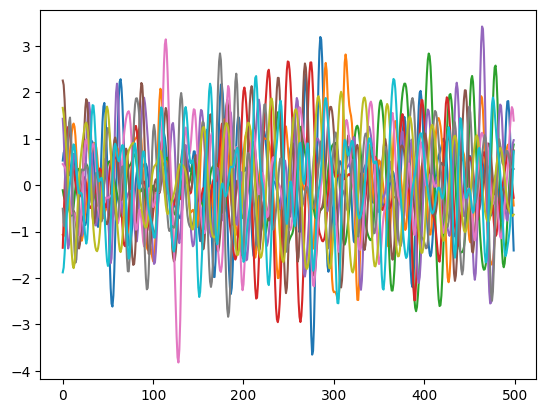

In [17]:
samples = 10 if x_gen.shape[0] > 10 else x_gen.shape[0]

for j in range(2):     
    x_gen = class_con[j]
    for i in range(samples):
        plt.plot(x_gen[i][0][:])
    plt.show()
    for i in range(samples):
        # rnd = np.random.random_integers(0,x_train.shape[0],size = samples)
        # plt.plot(x_train[rnd[i]][0][:])
        plt.plot(x_train[10*j+i][0][:])

    plt.show()

In [18]:
z_test, z_gen = eval.compute_z(X_gen=x_gen)
z_test, z_train = eval.compute_z(X_gen=x_train)
z_test, z_aug = eval.compute_z(X_gen=x_aug)




In [24]:
fid,_ = eval.fid_score(z_test,z_gen)
fid2,_ = eval.fid_score(z_test,z_train)
fid3,_ = eval.fid_score(z_gen,z_aug)

In [25]:
fid, fid2, fid3

(3.563814375844088, 0.007849758534830166, 9.06963762354627)